Atividade de experimentação 77 Reconhecimento de emoções de fala RAVDESS - SER: Speech Emotion Recognition

Base de dados: Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)

Contém 7356 arquivos (tamanho total: 24,8 GB); O banco de dados contém 24 atores profissionais (12 mulheres, 12 homens), vocalizando duas declarações lexicalmente combinadas em um sotaque norte-americano neutro; falando as expressões em entonações calmas, felizes, tristes, zangadas, com medo, surpresa e desgosto ou cantando as expressões em entonações calmas, felizes, tristes, raivosas e temerosas assim totalizando 8 emoções; image.png

Cada expressão é produzida em dois níveis de intensidade emocional (normal, forte), com uma expressão neutra adicional.

Toda a base de dados está subdividida em 3 modalidades:

somente áudio (16 bits, 48kHz .wav) áudio-vídeo (720p H.264, AAC 48kHz, .mp4) somente vídeo (sem som). Nota: Não há arquivos de música para Actor_18.

Mais detalhes sobre a base de dados podem ser vistos na página oficial RAVDESS.

In [191]:
#Importando as bibliotecas

import os
import pathlib
from datetime import datetime
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
print(f'[INFO] tensorflow: {tf.__version__}')
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

[INFO] tensorflow: 2.16.1


Análise exploratória de dados (EDA)
Baixando e carregando os datasets: SPEECH/SONG

Neste projeto serão usados somente os arquivos de áudio contendo as expressões faladas(speech) e cantadas(song) devido a limitação de espaço disponível no Google Drive.

arquivos de fala (Audio_Speech_Actors) contém 1440 arquivos;
arquivos de música (Audio_Song_Actors) contém 1012 arquivos.

In [192]:
# Código para baixar e extrair o dataset de áudio
#!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O Audio_Speech_Actors_01-24.zip
#!unzip Audio_Speech_Actors_01-24.zip -d '/content/Audio_Speech_Actors'
#!rm Audio_Speech_Actors_01-24.zip
## Comando para Colab 

##Comando para Vscode
import os
import urllib.request
import zipfile

# URL do arquivo zip
url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip"

# Nome do arquivo zip
zip_filename = "Audio_Speech_Actors_01-24.zip"

# Diretório de destino para extrair o arquivo zip
extract_dir = "D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors/"

# Baixar o arquivo zip
urllib.request.urlretrieve(url, zip_filename)

# Extrair o arquivo zip
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remover o arquivo zip após a extração
os.remove(zip_filename)



Identificadores de nome de arquivo Cada um dos 7356 arquivos RAVDESS possui um nome de arquivo exclusivo. O nome do arquivo consiste em um identificador numérico de 7 partes (por exemplo, 03-02-01-01-01-01-01.wav). Esses identificadores definem as características do estímulo.

Modalidade (01 = AV completo, 02 = apenas vídeo, 03 = apenas áudio). Canal vocal (01 = fala, 02 = música). Emoção (01 = neutro, 02 = calmo, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso). Intensidade emocional (01 = normal, 02 = forte). NOTA: Não há intensidade forte para a emoção 'neutra'. Frase (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"). Repetição (01 = 1ª repetição, 02 = 2ª repetição). Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres). Exemplo para o arquivo Audio_Song_Actors/Actor_01/03-02-01-01-01-01-01.wav:

Modalidade 03: Apenas áudio Canal vocal 02: música Emoção 01: neutro Intensidade emocional 01: normal. NOTA: Não há intensidade forte para a emoção 'neutra'. Frase 01: "Kids are talking by the door" Repetição 01: 1ª repetição Ator 01: 1º ator - homem, já que o número de identificação do ator é impar'''

In [193]:
#Criando os datasets
modalitys = [] # Modalidade (01 = AV completo, 02 = apenas vídeo, 03 = apenas áudio).
voc_channels = [] # Canal vocal (01 = fala, 02 = música).
emotions = [] # Emoção (01 = neutro, 02 = calma, 03 = feliz, 04 = triste, 05 = zangado, 06 = com medo, 07 = nojo, 08 = surpreso).
intensitys = [] # Intensidade emocional (01 = normal, 02 = forte). NOTA: Não há intensidade forte para a emoção 'neutra'.
phrases =[] # Frase (01 = "Crianças conversam perto da porta", 02 = "Cachorros estão sentados na porta").
actors = [] # Ator (01 a 24. Os atores com números ímpares são homens, os atores com números pares são mulheres)

full_path = []

# Função para criar o dataset
def create_dataset(dataset):
  os.chdir(dataset)
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        modal = int(file[1:2])
        vchan = int(file[4:5])
        label = int(file[7:8])
        ints = int(file[10:11])
        phr = int(file[13:14])
        act = int(file[19:20])

        modalitys.append(modal)
        voc_channels.append(vchan)
        emotions.append(label)
        intensitys.append(ints)
        phrases.append(phr)
        actors.append(act)

        full_path.append((root, file))
      except ValueError:
        continue

In [194]:
import os

dir_dataset = 'D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors/'

if os.path.exists(dir_dataset):
    print("O diretório existe.")
else:
    print("O diretório não existe.")

O diretório existe.


In [195]:
# Cria datasets a partir dos arquivos de áudio
create_dataset(dir_dataset)

25it [00:00, 49.06it/s]


In [196]:
# Mostra o tamanho do dataset de áudio
len(full_path)

1440

In [197]:
# Mapeia emoções para rótulos textuais
emotions_list = ['neutra', 'calma', 'feliz', 'triste', 'nervosa', 'medo', 'nojo', 'surpreso']
emotion_dict = {em[0] + 1:em[1] for em in enumerate(emotions_list)}
emotion_dict

{1: 'neutra',
 2: 'calma',
 3: 'feliz',
 4: 'triste',
 5: 'nervosa',
 6: 'medo',
 7: 'nojo',
 8: 'surpreso'}

In [198]:
# Cria DataFrame com as informações extraídas
df = pd.DataFrame([emotions, voc_channels, modalitys, intensitys, actors, phrases, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,1,1,3,1,1,1,(D:/Dados/Material_complementar_reconhecimento...
1,1,1,3,1,1,1,(D:/Dados/Material_complementar_reconhecimento...
2,1,1,3,1,1,2,(D:/Dados/Material_complementar_reconhecimento...
3,1,1,3,1,1,2,(D:/Dados/Material_complementar_reconhecimento...
4,2,1,3,1,1,1,(D:/Dados/Material_complementar_reconhecimento...
...,...,...,...,...,...,...,...
1435,8,1,3,1,4,2,(D:/Dados/Material_complementar_reconhecimento...
1436,8,1,3,2,4,1,(D:/Dados/Material_complementar_reconhecimento...
1437,8,1,3,2,4,1,(D:/Dados/Material_complementar_reconhecimento...
1438,8,1,3,2,4,2,(D:/Dados/Material_complementar_reconhecimento...


In [199]:
# Mapeia valores numéricos para rótulos de texto no DataFrame
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'fala', 2: 'musica'})
df['modality'] = df['modality'].map({1: 'AV completo', 2: 'apenas video', 3: 'apenas audio'})
df['intensity'] = df['intensity'].map({1: 'normal', 2: 'forte'})
df['actors'] = df['actors'].apply({lambda x: 'feminino' if x % 2 == 0 else 'masculino'})
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2: 'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])
df

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,neutra,fala,apenas audio,normal,masculino,Kids are talking by the door,D:/Dados/Material_complementar_reconhecimento_...
1,neutra,fala,apenas audio,normal,masculino,Kids are talking by the door,D:/Dados/Material_complementar_reconhecimento_...
2,neutra,fala,apenas audio,normal,masculino,Dogs are sitting by the door,D:/Dados/Material_complementar_reconhecimento_...
3,neutra,fala,apenas audio,normal,masculino,Dogs are sitting by the door,D:/Dados/Material_complementar_reconhecimento_...
4,calma,fala,apenas audio,normal,masculino,Kids are talking by the door,D:/Dados/Material_complementar_reconhecimento_...
...,...,...,...,...,...,...,...
1435,surpreso,fala,apenas audio,normal,feminino,Dogs are sitting by the door,D:/Dados/Material_complementar_reconhecimento_...
1436,surpreso,fala,apenas audio,forte,feminino,Kids are talking by the door,D:/Dados/Material_complementar_reconhecimento_...
1437,surpreso,fala,apenas audio,forte,feminino,Kids are talking by the door,D:/Dados/Material_complementar_reconhecimento_...
1438,surpreso,fala,apenas audio,forte,feminino,Dogs are sitting by the door,D:/Dados/Material_complementar_reconhecimento_...


In [200]:
#Visualizando a distribuição

# Visualiza a distribuição das emoções
df.describe()

,emotion,voc_channel,modality,intensity,actors,phrase,path
count,1440,1440,1440,1440,1440,1440,1440
unique,8,1,1,2,2,2,1440
top,calma,fala,apenas audio,normal,masculino,Kids are talking by the door,D:/Dados/Material_complementar_reconhecimento_...
freq,192,1440,1440,768,720,720,1


In [201]:
# Cria um arquivo csv com os dados da distribuição
dir_dados_distr = "D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors"
file_csv = 'Audio_Actors_metadata.csv'
df.to_csv(os.path.join(dir_dados_distr, file_csv), index = False)

In [202]:
# Visualiza a quantidade de áudios para cada emoção
df.emotion.value_counts()

emotion
calma       192
feliz       192
triste      192
nervosa     192
medo        192
nojo        192
surpreso    192
neutra       96
Name: count, dtype: int64

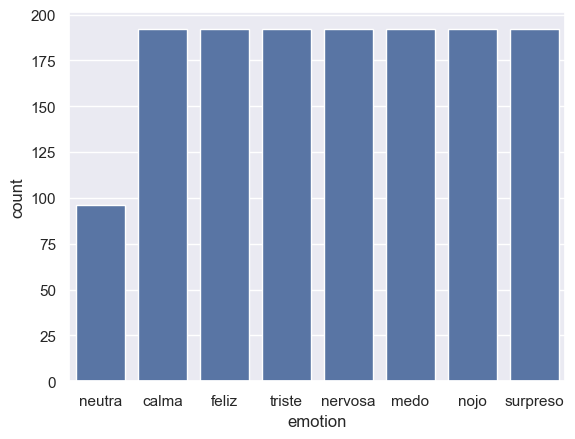

In [203]:
# Visualização gráfica
sns.countplot(df, x='emotion');

Canais: (205005,)
Número total de amostras: 205005
Arquivo:  D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors/Actor_12/03-01-05-01-01-01-12.wav
Taxa de amostragem: 48000
Duração:  4.2709375


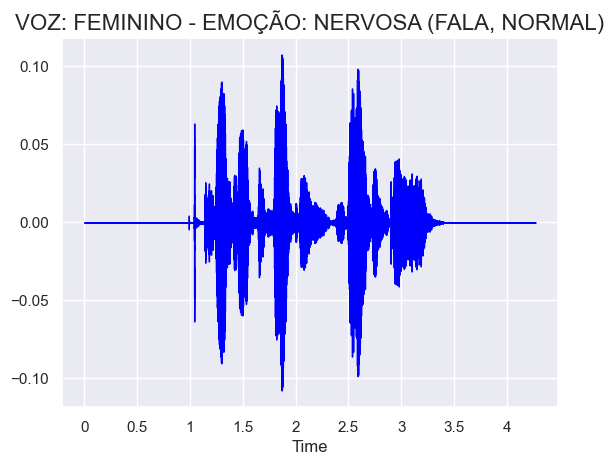

In [204]:
#Visualizando os dados de áudio

# Visualiza formas de onda e espectrogramas dos dados de áudio
n_files = df.shape[0]
rnd = np.random.randint(0, n_files)

fname = df.path[rnd]
data, sample_rate = librosa.load(fname, sr=None)

print('Canais:', data.shape)
print('Número total de amostras:', data.shape[0])
print('Arquivo: ', fname)
print('Taxa de amostragem:', sample_rate)
print('Duração: ', len(data) / sample_rate)

info = df.iloc[rnd].values
title_txt = f'voz: {info[4]} - emoção: {info[0]} ({info[1]}, {info[3]})'
plt.title(title_txt.upper(), size=16)
ld.waveshow(data, sr=sample_rate, color = 'blue')
Audio(data = data, rate = sample_rate)

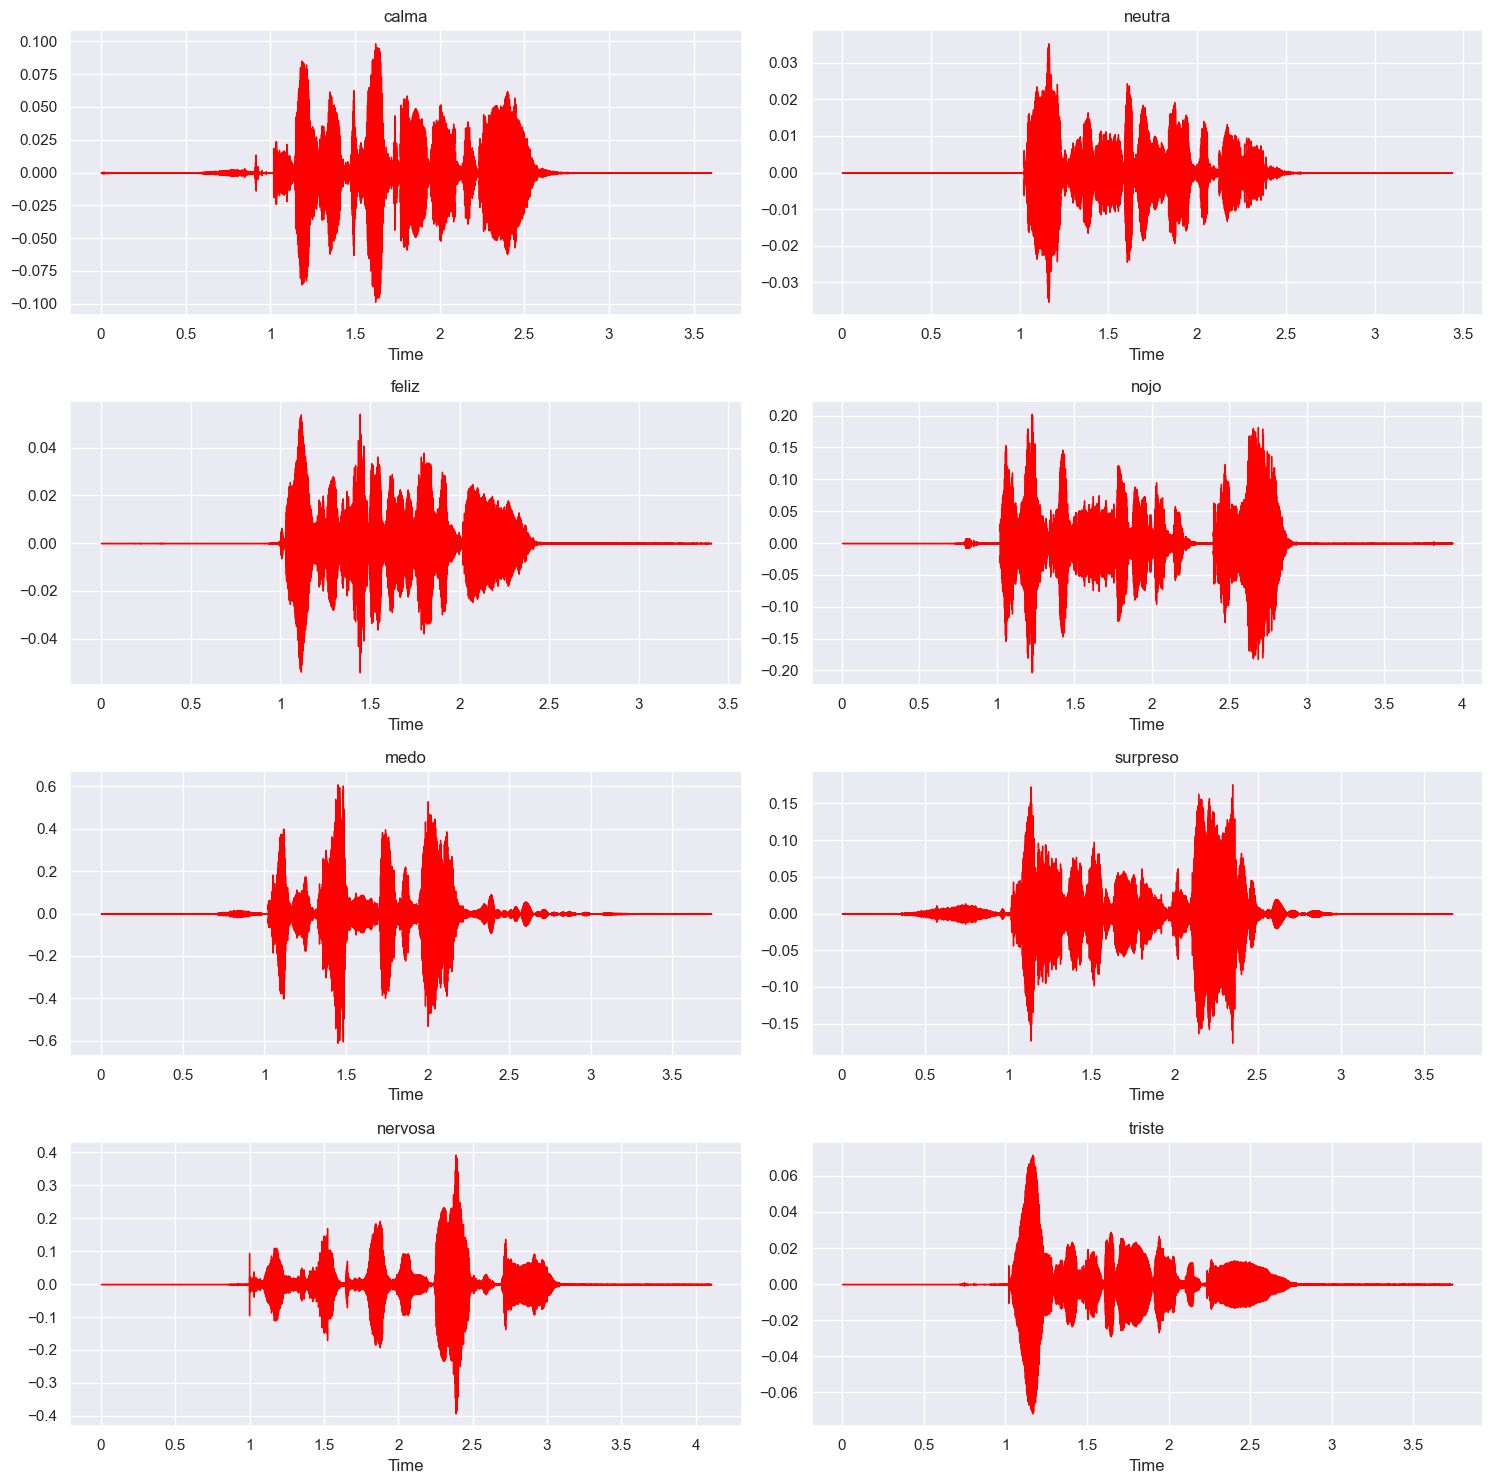

In [205]:
# Escolha aleatória de visualizações de formas de onda e espectrogramas de cada emoção
random_samples = df.groupby('emotion').sample(1)
audio_samples, labels = random_samples['path'].tolist(), random_samples['emotion'].tolist()

rows=4
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        librosa.display.waveshow(data, sr=sample_rate,color = 'red', ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

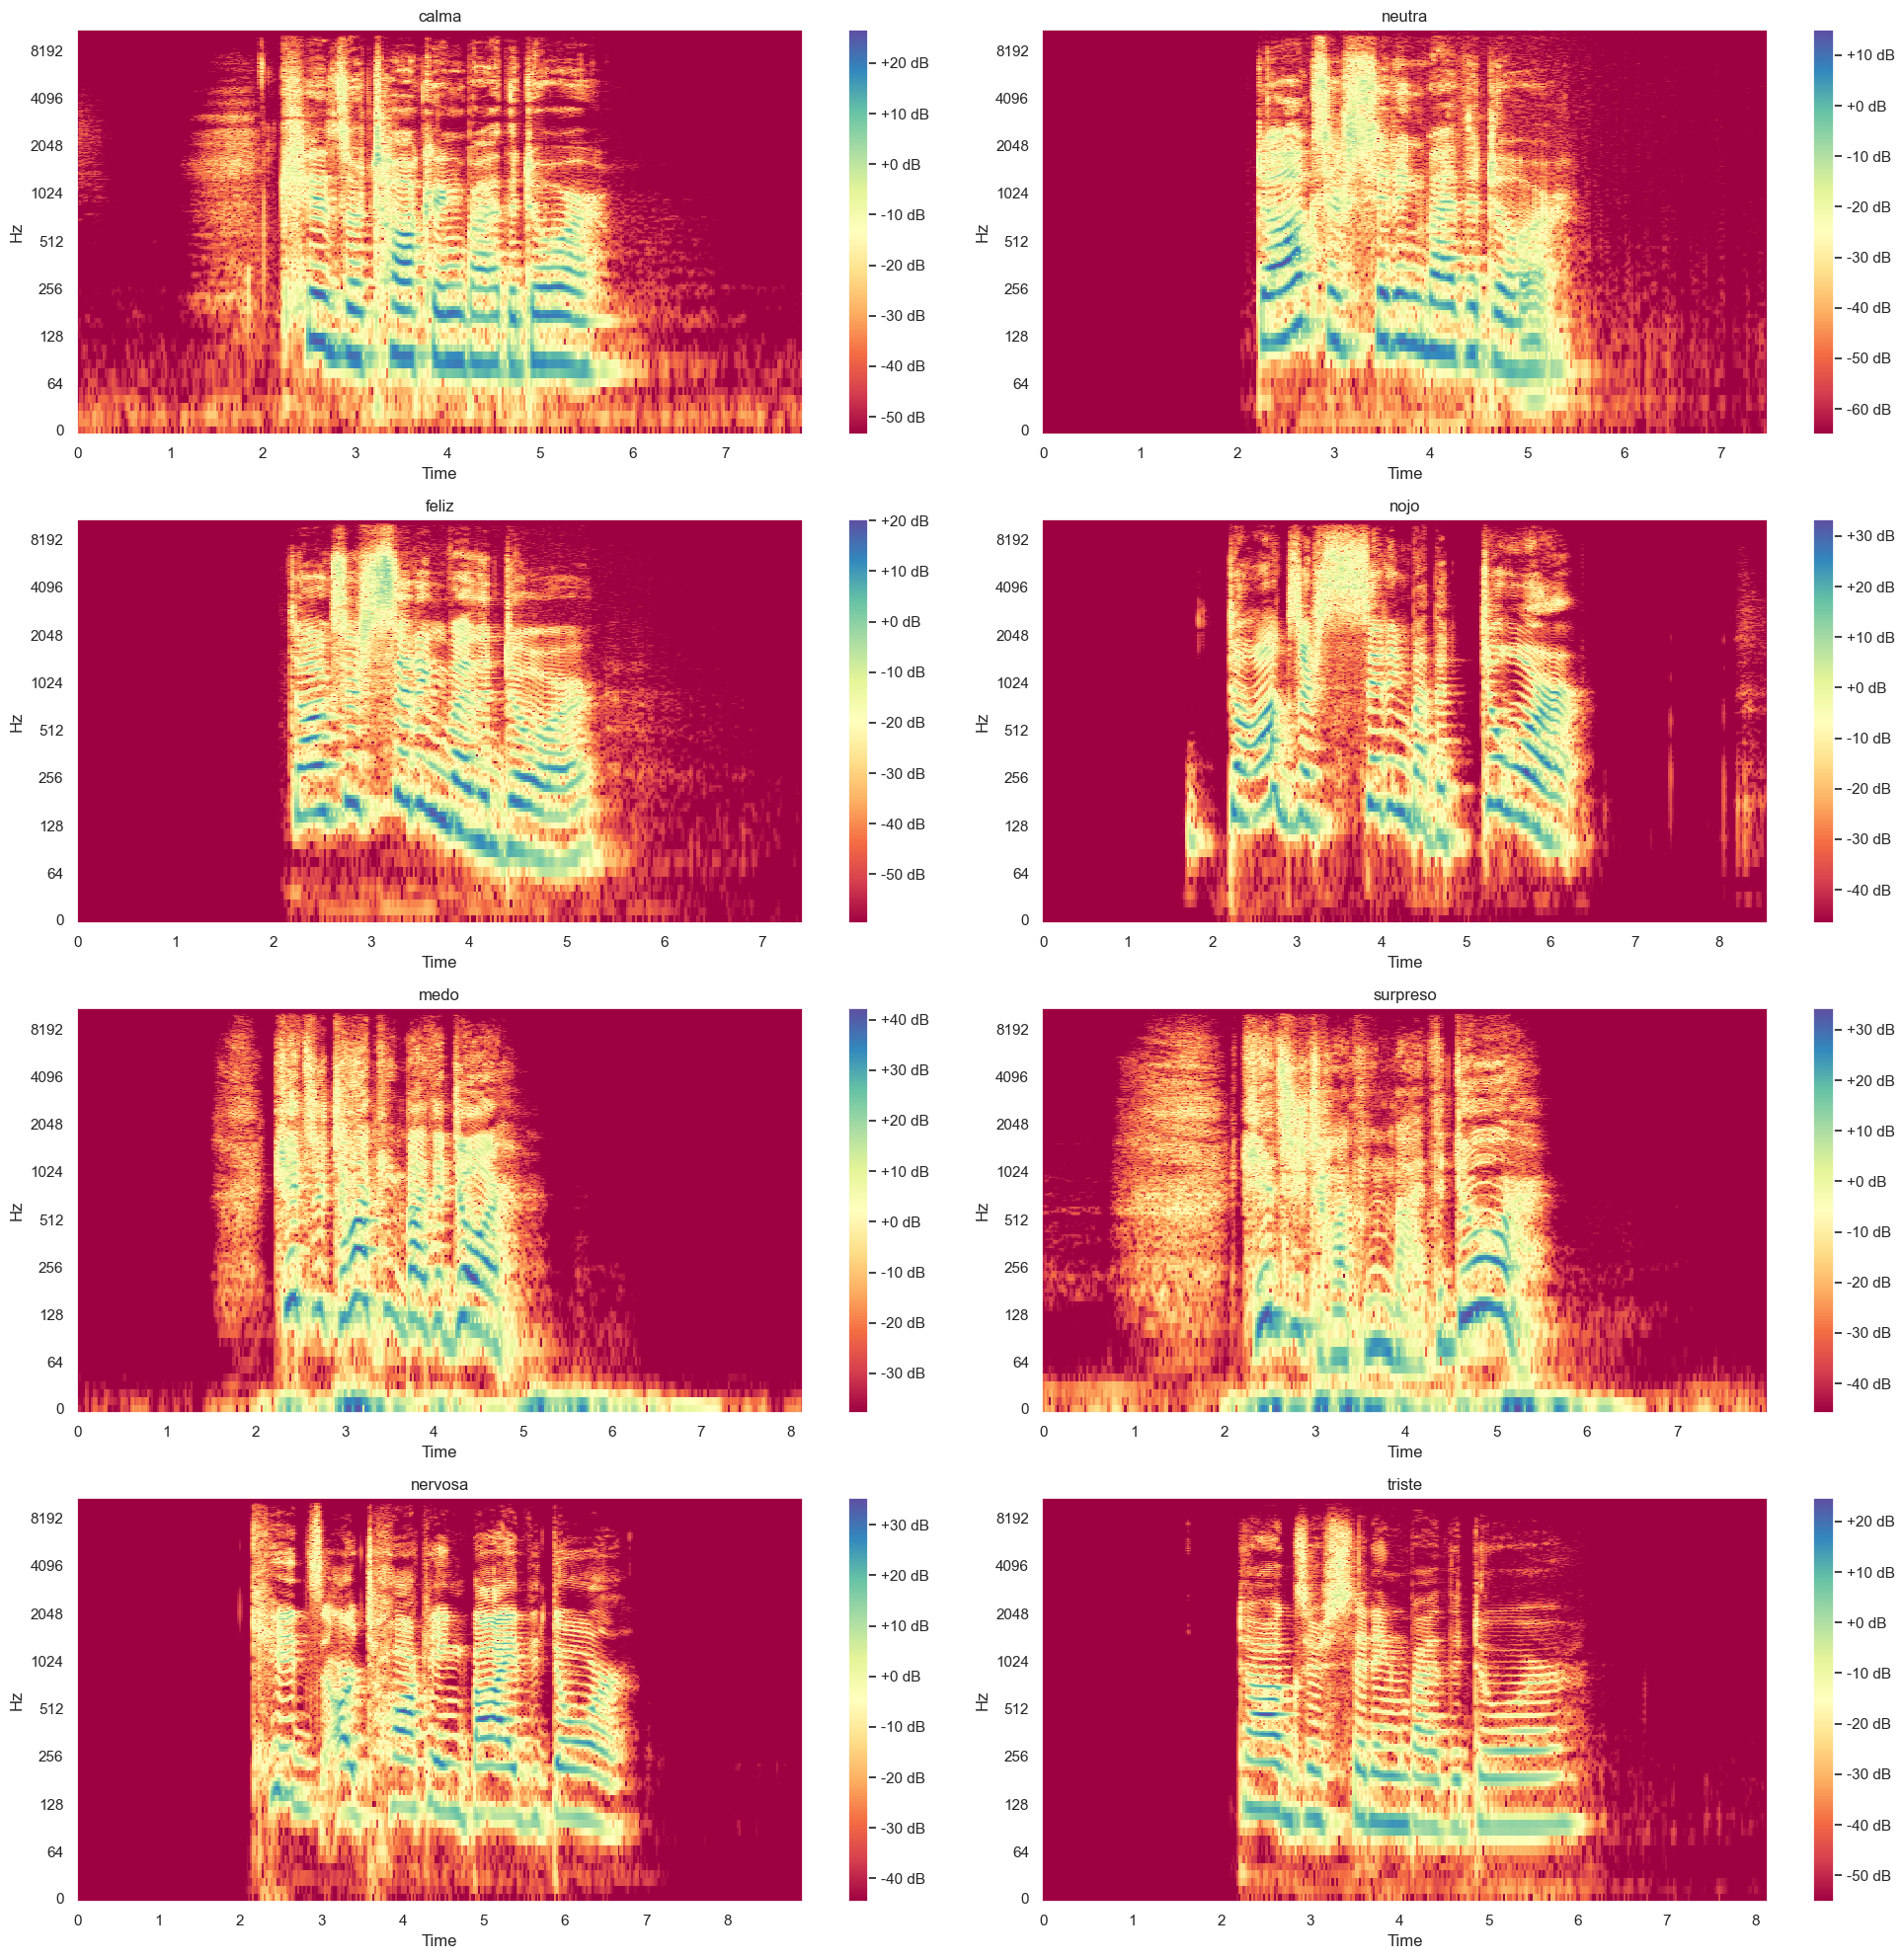

In [206]:
#Espectrogramas de STFT

# Cria o espectrograma para cada uma das emoções
fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        stft = librosa.stft(y = data)
        stft_db = librosa.amplitude_to_db(np.abs(stft))
        img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1
fig.tight_layout()

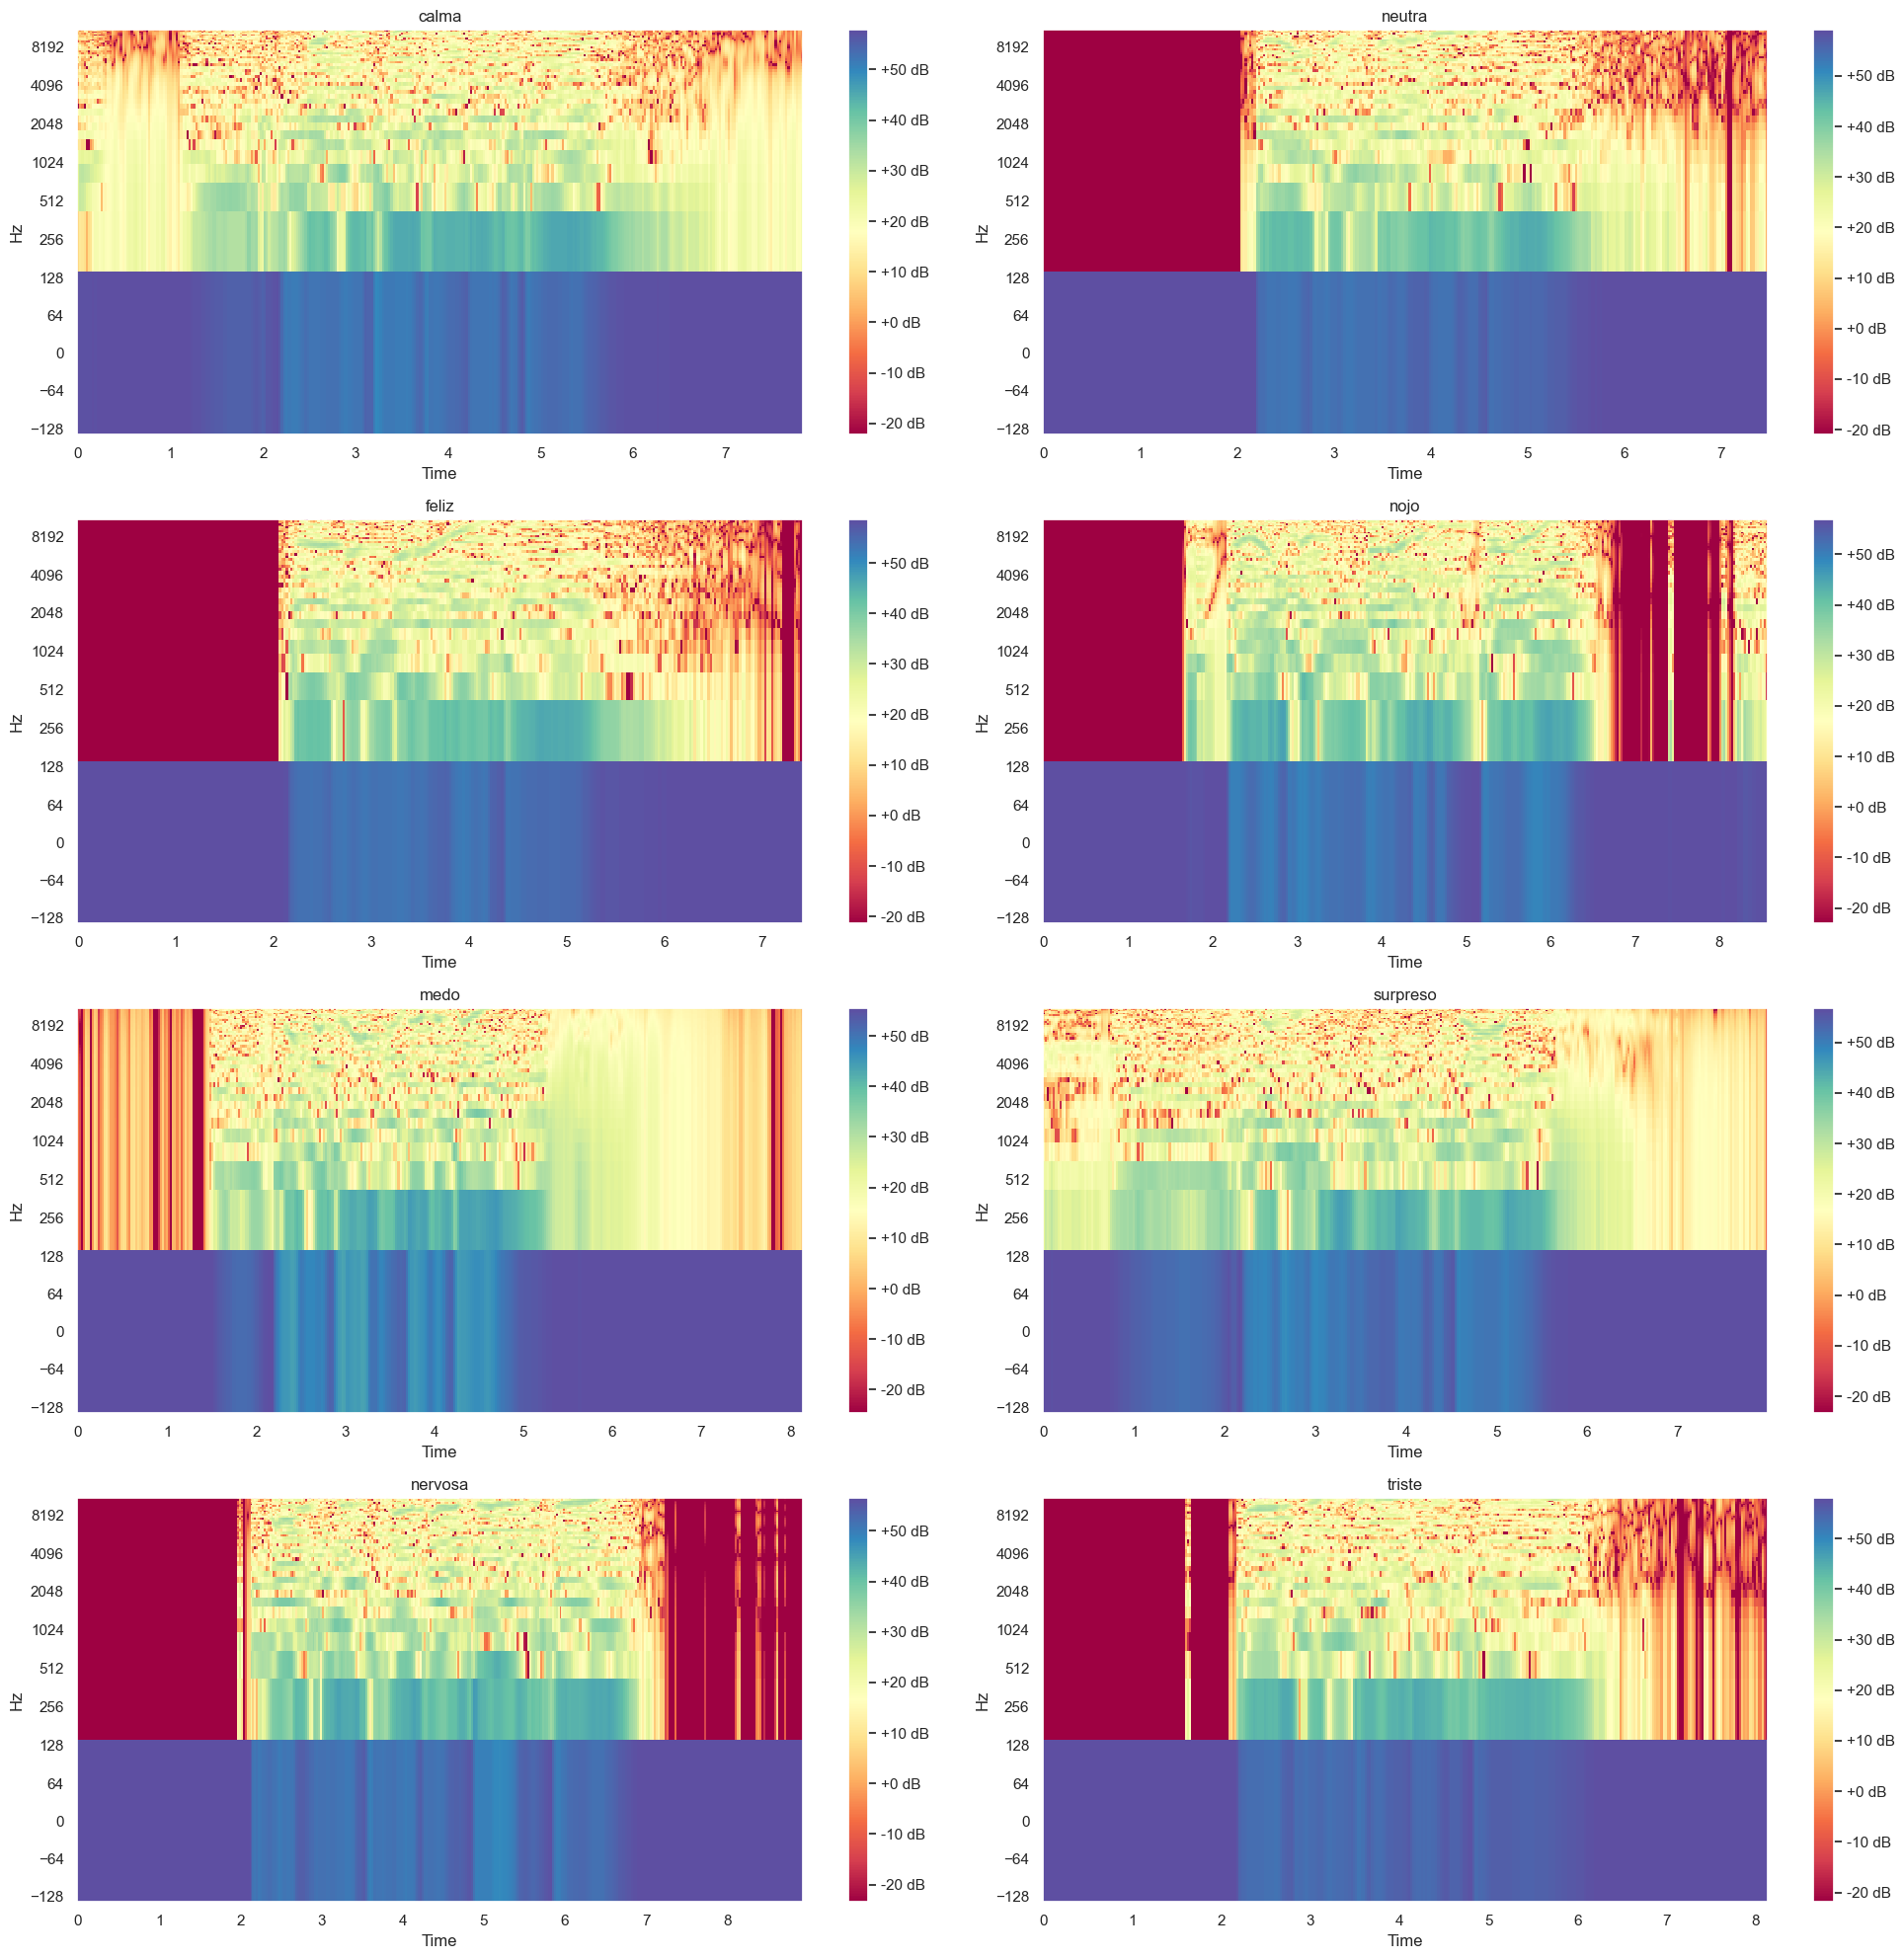

In [207]:
#Espectrogramas de MFCCs

fig, axs = plt.subplots(rows, cols, figsize=(20,20))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

In [208]:
#Pré-processamento

#Extraindo recursos/características MFCC's de cada arquivo de áudio do dataset
# Extrai características MFCC
def features_extractor(file_name):
    data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

extracted_features=[]
for path in tqdm(df.path.values):
  data = features_extractor(path)
  extracted_features.append([data])

100%|██████████| 1440/1440 [00:29<00:00, 48.42it/s]


In [209]:
#Convertendo os recursos extraídos para visualização com Pandas

# Converte os recursos extraídos em DataFrame para visualização
extracted_features_df = pd.DataFrame(extracted_features, columns = ['feature'])

In [210]:
#Dividindo entre atributos classe(class) e atributos previsores(features)

# Divide os dados em atributos de classe e atributos previsores
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(df.emotion.tolist())

# Cria um objeto para converter rótulos categóricos em valores numéricos
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

# Classes identificadas
labelencoder.classes_

# Divide os dados em conjuntos de treinamento e teste.
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Adiciona uma nova dimensão aos dados de treinamento e teste.
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

# Quantidade de classes de emoções
num_labels = y.shape[1]
num_labels

8

Criando o modelo Criação da estrutura da rede neural

Os espectrogramas extraídos dos arquivos de áudio são como imagens 2D, então podemos usar técnicas de classificação de imagens neles, especificamente Redes Neurais Convolucionais (CNN)!

A arquitetura desta rede neural foi definida com base em alguns testes realizados para obter o resultado esperado. A estrutura pode ser ajustada livremente e comparada aos resultados desta estrutura.

Parâmetros: Sequential, é a classe para criar a rede neural, pois uma rede neural nada mais é que uma sequência de camadas (camada e entrada, camadas ocultas, camada de saída); kernel_size, o tamanho do kernel (matriz) de convolução; activation, função de ativação; input_shape, na primeira camada este é o tamanho dos dados de entrada Camada MaxPooling1D, que vai fazer a extração das características principais; Camada Conv1d, uma rede neural convolucional que realiza a convolução ao longo de apenas uma dimensão; Camada Flatten, para transformar de matriz em vetor; Camada Dense, quando um neurônio de uma camada está ligado a todas os outros neurônios das outras camadas; Dropout, técnica de regularização para diminuir o overfitting; padding='same', indica que adicionamos uma nova coluna composta por somente 0 (zeros) e utilizamos toda a imagem;

In [211]:
# Cria o modelo de rede neural
model=Sequential()

model.add(Conv1D(64, kernel_size=(5), activation='relu',input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))

model.add(Conv1D(256, kernel_size=(5),activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

d:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 36, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 36, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 7, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,536 (869.28 KB)

 Trainable params: 222,536 (869.28 KB)

 Non-trainable params: 0 (0.00 B)

Treinando o modelo num_epochs, número de épocas de treinamento num_batch_size, isto indica que vamos enviar de 32 em 32 recursos de áudio (32, 64, 96, 128,...8732) ModelCheckpoint, para salvar o modelo enquanto faz o treinamento

filepath, caminho onde será salvo o modelo. Para isto temos uma pasta no Drive chamada saved_models verbose, mostrar mensagens enquanto a rede neural é treinada save_best_only = True, para salvar o modelo somente quando houver uma melhora no resultado Variáveis para efetuar a contagem do tempo de treinamento:

start, pegando o horário atual de início do treinamento; duration, ao final do treinamento, subtrair a hora atual com hora de início do treinamento. model_history para armazenar o histórico de treinamento:

model.fit para fazer o ajuste do pesos ao longo do treinamento X_train, Y_train, dados de treinamento batch_size = num_batch_size que definimos acima epochs = num_epochs que também definimos acima validation_data=(X_test, Y_test), dados de teste para monitorarmos como está o percentual de acerto da rede neural a cada época callbacks=[checkpointer], checkpointer definido anteriormente verbose = 1, para mostrar as mensagens

In [212]:
# Montagem do Google Drive para acessar arquivos armazenados
#from google.colab import drive
#drive.mount('/content/gdrive')

# Realize o dowload da pasta Material_complementar_reconhecimento_voz.zip do Google Sala de Aula e transfira-a para o seu Google Drive
# Localize o caminho da pasta no menu Arquivos, no menu lateral esquerdo
import zipfile
#path = "/content/gdrive/MyDrive/Material_complementar_reconhecimento_voz.zip"
#zip_object = zipfile.ZipFile(file=path, mode="r")
#zip_object.extractall("./")

In [213]:
# Treina o modelo conforme o modelo já treinado disponível na pasta modelos do Material_complementar_reconhecimento_voz.zip
num_epochs = 50
num_batch_size = 64

dir_modelo_train = "D:/Dados/Material_complementar_reconhecimento_voz/modelos/speech_emotion_recognition.keras"
checkpointer = ModelCheckpoint(filepath=dir_modelo_train,
                               verbose=1, save_best_only=True)
start = datetime.now()
model_history = model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs,
                          validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("[INFO] treinamento concluído em: ", duration)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1648 - loss: 5.4837
Epoch 1: val_loss improved from inf to 2.07636, saving model to D:/Dados/Material_complementar_reconhecimento_voz/modelos/speech_emotion_recognition.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.1644 - loss: 5.4027 - val_accuracy: 0.1181 - val_loss: 2.0764
Epoch 2/50
16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1364 - loss: 2.1509
Epoch 2: val_loss improved from 2.07636 to 2.07359, saving model to D:/Dados/Material_complementar_reconhecimento_voz/modelos/speech_emotion_recognition.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.1384 - loss: 2.1438 - val_accuracy: 0.0972 - val_loss: 2.0736
Epoch 3/50
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1747 - loss: 2.0936
Epoch 3: val_loss improved from 2.07359 to 2.05612, saving model to D:/Dados/Material_complementar_reconhecimento_voz/modelos/speech_emotion_recognition.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 

In [214]:
#Avaliando o modelo

# Avalia o desempenho do modelo treinado usando o conjunto de teste.
model.evaluate(X_test,Y_test, verbose=0)

# Imprime as chaves do dicionário 'history' que contém os registros do histórico de treinamento do modelo.
print(model_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


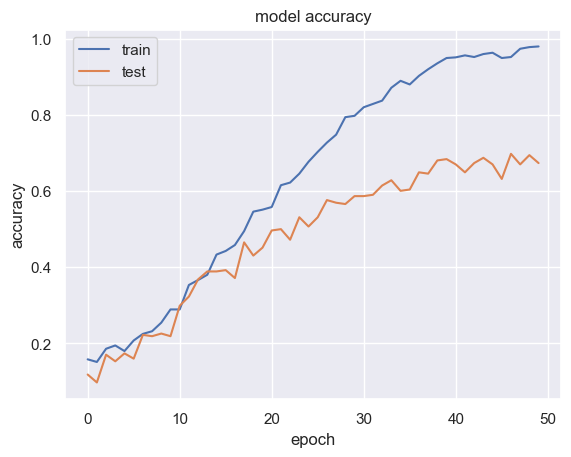

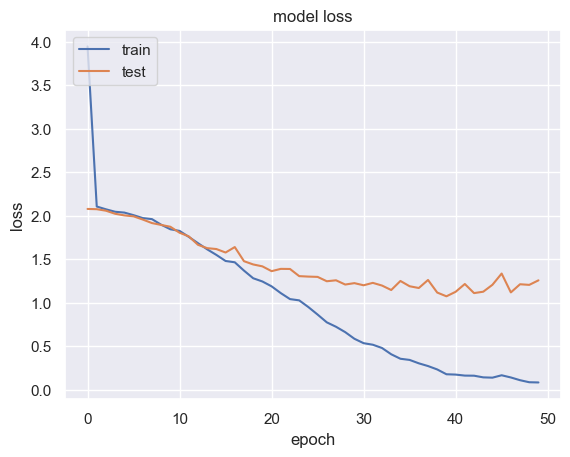

In [215]:
# Plota o gráfico da precisão (accuracy) e perda (loss) do modelo durante o treinamento e a validação.
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [216]:
#Comparando as classes reais com as classes previstas

# Compara classes reais com as previstas
predictions = model.predict(X_test)

# Converte as probabilidades das previsões em rótulos de classe. Cada previsão contém um conjunto de probabilidades para cada classe.
predictions = predictions.argmax(axis=1)

# Converte os índices de previsão em inteiros e os achata em um array unidimensional. Isso é necessário para processar as previsões.
predictions = predictions.astype(int).flatten()
predictions = (labelencoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Classes Previstas': predictions})
predictions

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


,Classes Previstas
0,nojo
1,nervosa
2,medo
3,surpreso
4,surpreso
...,...
283,calma
284,nojo
285,nojo
286,feliz


In [217]:
# Converte a matriz de rótulos de teste (Y_test) para obter o índice da classe com a maior probabilidade (classe real) para cada amostra.
actual = Y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (labelencoder.inverse_transform((actual)))
actual = pd.DataFrame({'Classes Reais': actual})
actual

,Classes Reais
0,nojo
1,nervosa
2,medo
3,surpreso
4,surpreso
...,...
283,calma
284,calma
285,triste
286,feliz


In [218]:
# Combina os DataFrames 'actual' e 'predictions' para criar um novo DataFrame chamado 'finaldf'.
finaldf = actual.join(predictions)
finaldf[140:150]

,Classes Reais,Classes Previstas
140,triste,triste
141,nervosa,nervosa
142,calma,calma
143,medo,medo
144,nervosa,nervosa
145,neutra,neutra
146,feliz,feliz
147,nojo,nojo
148,medo,medo
149,feliz,feliz


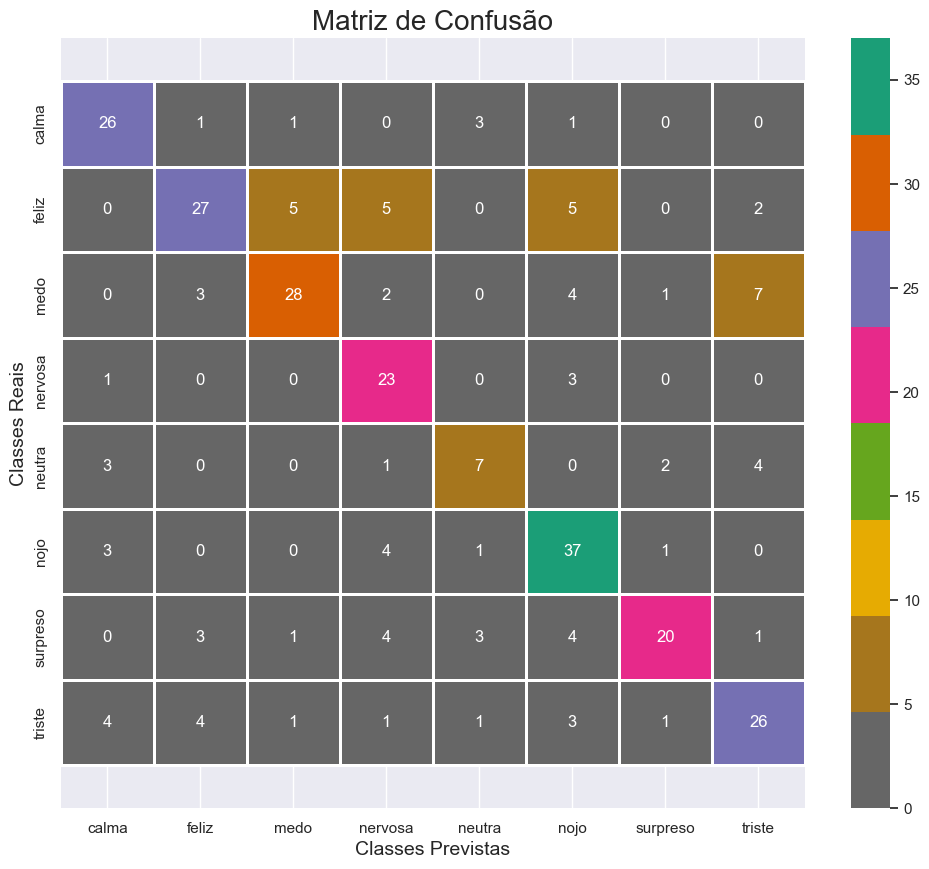

In [219]:
#Exibindo a Matriz de confusão

cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in labelencoder.classes_] , columns = [i for i in labelencoder.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Dark2_r', linewidth=1, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de Confusão', size=20)
plt.xlabel('Classes Previstas', size=14)
plt.ylabel('Classes Reais', size=14)
plt.show()

In [220]:
#Visualizando a taxa e acerto para cada uma das classes

print(classification_report(actual, predictions))

              precision    recall  f1-score   support

       calma       0.70      0.81      0.75        32
       feliz       0.71      0.61      0.66        44
        medo       0.78      0.62      0.69        45
     nervosa       0.57      0.85      0.69        27
      neutra       0.47      0.41      0.44        17
        nojo       0.65      0.80      0.72        46
    surpreso       0.80      0.56      0.66        36
      triste       0.65      0.63      0.64        41

    accuracy                           0.67       288
   macro avg       0.67      0.66      0.66       288
weighted avg       0.69      0.67      0.67       288



In [221]:
# Exemplo de uso
import os
import random
from PIL import Image
import matplotlib.pyplot as plt


def file_auto():

    def escolher_arquivo_aleatorio(caminho_da_pasta):
        # Lista todos os arquivos na pasta
        arquivos = os.listdir(caminho_da_pasta)
    
        # Filtra apenas os arquivos (remove pastas)
        arquivos = [arquivo for arquivo in arquivos if os.path.isfile(os.path.join(caminho_da_pasta, arquivo))]
    
        # Escolhe um arquivo aleatoriamente
        arquivo_aleatorio = random.choice(arquivos)
    
        # Retorna o caminho completo do arquivo escolhido
        return os.path.join(caminho_da_pasta, arquivo_aleatorio)

    # Funcao Gerar numero
    def num_aleat(num_min,num_max):
        import random
        num_ger = random.randrange(num_min,num_max)
        return num_ger




    # Gera um numero aleatorio de 1 a 4 para os diretorios 
    # Por funcao retorma o numero o numero aleatorio
    num_ger = num_aleat(1,24)

    if num_ger >= 1:
        if num_ger <= 9:
            caminho_da_pasta = "D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors/Actor_" + '0' +  str(num_ger)
        else:
            caminho_da_pasta = "D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors/Actor_" + str(num_ger)

    # Apos diretorio aleatorio, escolhe arquivo aleatorio para analise
    # Assim é possivel juntar mais de um diretório
    arquivo_aleatorio = escolher_arquivo_aleatorio(caminho_da_pasta)
    print("Arquivo escolhido aleatoriamente:", arquivo_aleatorio)

    return(arquivo_aleatorio)

In [223]:
#Testando o modelo em arquivos de áudio

def getInfo(data, sample_rate):
  print('Canais: ', data.shape)
  print('Número total de amostras: ', data.shape[0])
  print('Taxa de amostragem: ', sample_rate)
  print('Duração: ',  len(data) / sample_rate)

def predictSound(AUDIO, info = False, plot_waveform = False, plot_spectrogram = False):
  audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]
  predictions = model.predict(mfccs_scaled_features)
  plt.barh(labelencoder.classes_, predictions[0], color=list('rgbkymc'))
  predictions = predictions.argmax(axis=1)
  predictions = predictions.astype(int).flatten()
  predictions = (labelencoder.inverse_transform((predictions)))
  print('Resultado:', predictions)

  if info:
    getInfo(audio, sample_rate)

  if plot_waveform:
    plt.figure(figsize=(14,5))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    plt.xlabel("Tempo (segundos) ==>")
    plt.ylabel("Amplitude")
    ld.waveshow(audio, sr=sample_rate)

  if plot_spectrogram:
    plt.figure(figsize=(14,5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
    plt.title('Emoção: ' + str(predictions[0]).upper(), size=16)
    ld.specshow(mfccs_db, x_axis="time", y_axis='log', cmap = 'Spectral')
    plt.colorbar(format='%+2.f dB')


#AUDIO = "D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors/Actor_02/03-01-02-01-01-01-02.wav" # Teste diferentes áudios
AUDIO = file_auto()
audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
Audio(data = audio, rate = sample_rate)

Arquivo escolhido aleatoriamente: D:/Dados/Material_complementar_reconhecimento_voz/Audio_Speech_Actors/Actor_20\03-01-06-02-02-02-20.wav
